In [84]:
from kafka import KafkaConsumer
import pickle
from openbci_stream.acquisition import Cyton
from openbci_stream.acquisition import CytonConstants as cnt
import time
import numpy as np
from matplotlib import pyplot as plt
import rawutil

def show(data):
    plt.figure(figsize=(20, 10), dpi=90)
    
    plt.subplot(211)
    plt.axis('off')
    plt.imshow(data.T, aspect='auto')
    
    plt.subplot(212)
    
    eeg_data = data[:,2:26]
    
#     eeg = np.array([[rawutil.unpack('>u',bytes(ch))[0] for ch in row.reshape(-1, 3)] for row in eeg_data])
    eeg = np.array([[rawutil.unpack('>u',bytes(ch))[0] for ch in row.reshape(-1, 3).tolist()] for row in eeg_data])

    scale_factor_for_v = 4.5 / (24 * ((2 ** 23) - 1))
    scale_factor_for_uv = 4500000 / (24 * ((2 ** 23) - 1))
    

    eeg_v = eeg * scale_factor_for_v
    eeg_uv = eeg * scale_factor_for_uv
    
    [plt.plot(ch+(i*1.5e4)-ch.mean()) for (i, ch) in enumerate(eeg_uv.T)]
    plt.yticks(np.arange(8)*1.5e4, [f'ch{ch+1}' for ch in range(8)])

#     [plt.plot(ch+i-ch.mean()) for (i, ch) in enumerate(eeg.T)]
#     plt.yticks(range(8), [f'ch{ch+1}' for ch in range(8)])
#     plt.show()
    plt.xlim(0, eeg_data.shape[0])
    plt.axis('off')

# Appendix 1 - Raw data processing

## Data cleaning

This appendix describes the process to validate RAW data according to the [official guide](https://docs.openbci.com/docs/02Cyton/CytonDataFormat), this procces must be implemented before to the deserialization.

In [3]:
BIN_HEADER = 0xa0

In [13]:
consumer_binary = KafkaConsumer(bootstrap_servers=['localhost:9092'],
                                     value_deserializer=pickle.loads,
                                     auto_offset_reset='latest',
                                     )
consumer_binary.subscribe(['binary'])


openbci = Cyton('serial', '/dev/ttyUSB1', capture_stream=True, daisy=False)
openbci.command(cnt.DEFAULT_CHANNELS_SETTINGS)
openbci.command(cnt.TEST_2X_SLOW)
openbci.start_stream()

binary = b''
for message in consumer_binary:
    binary += message.value['data']
    
    if len(binary) >= (250*33*10):
        openbci.stop_stream()
        break

In [65]:
data = np.array(list(binary))
raw_data = data.copy()

The raw data is reshaped with `33 bytes` width.

We just need to align the array with the `BIN_HEADER` (top of image) each `33 bytes`.

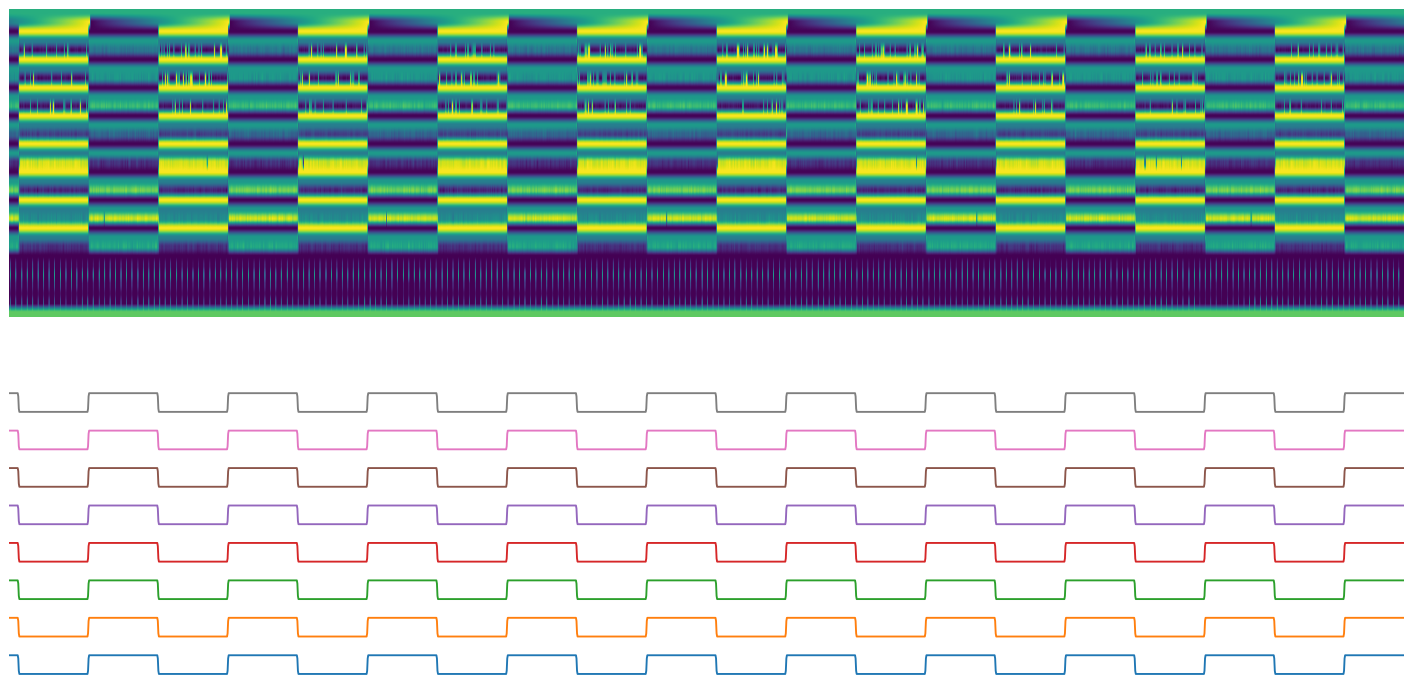

In [85]:
# Search for the the first index with a `BIN_HEADER`
start = [np.median(np.roll(data, -i, axis=0)[::33]) == BIN_HEADER for i in range(33)].index(True)

# Fix the offset to complete 33 bytes divisible array 
end = (data.shape[0]-start)%33

data_align = data[start:-end]
data_align = data_align.reshape(-1, 33)

# The offset could be used for the next binary data
remnant = binary[-end:]

show(data_align)

## Binary deserialization

This appendix describes the process of convert validated RAW data into EEG data packages, according to the [official guide](https://docs.openbci.com/docs/02Cyton/CytonDataFormat).

### EEG deserialization

In [46]:
eeg_data = data_align[:, 2:26]
eeg_data.shape

(2559, 24)

This 24 elements of `8 bits` each contain 8 elements of `24 bits`, for example, for the first row:

In [47]:
row = eeg_data[0]
row.shape, row

((24,),
 array([  2, 138,  98,   2, 138, 121,   2, 137, 166,   2, 138,  81,   2,
        138,  30,   2, 138, 213,   2, 138, 235,   2, 138, 145]))

In [48]:
row = row.reshape(-1, 3) # 3 bytes
row.shape, row

((8, 3),
 array([[  2, 138,  98],
        [  2, 138, 121],
        [  2, 137, 166],
        [  2, 138,  81],
        [  2, 138,  30],
        [  2, 138, 213],
        [  2, 138, 235],
        [  2, 138, 145]]))

#### Signed 24-bits (3 bytes) integer to Signed 32-bits integer

In [49]:
def assert_(stct, data, validate):
    value = rawutil.unpack(stct, data)[0]
    if  value == validate:
        print(f'OK | {value} = {validate}')
    else:
        print(f'NO | {value} != {validate}')

format_ = '>u'
        
assert_(format_, [0x7F, 0xFF, 0xFF], 8388607)  # max
assert_(format_, [0xFF, 0xFF, 0xFF], -1)       # mid
assert_(format_, [0x80, 0x00, 0x01], -8388607) # min
assert_(format_, [0x5D, 0xCB, 0xED], 6147053)  # other
assert_(format_, [0xA2, 0x34, 0x13], -6147053) # other inverted

OK | 8388607 = 8388607
OK | -1 = -1
OK | -8388607 = -8388607
OK | 6147053 = 6147053
OK | -6147053 = -6147053


With the correct unpack method, we can unpack the complete array by iteration:

In [50]:
eeg = np.array([[rawutil.unpack('>u',bytes(ch))[0] for ch in row.reshape(-1, 3).tolist()] for row in eeg_data])
eeg.shape, eeg[0]

((2559, 8),
 array([166498, 166521, 166310, 166481, 166430, 166613, 166635, 166545]))

### Signed 32-bits to Volts

The `ADS1299` give us a `scale factor` to convert the `counts` to volts (or microvolts), it depends on `gain` and a reference voltage

In [51]:
gain = 24
vref = 4.5 # in volts

scale_factor_for_v = vref / (gain * ((2 ** 23) - 1))
scale_factor_for_uv = vref*1e6 / (gain * ((2 ** 23) - 1))

scale_factor_for_v, scale_factor_for_uv

(2.235174445530706e-08, 0.022351744455307063)

In [52]:
eeg_v = eeg * scale_factor_for_v
eeg_uv = eeg * scale_factor_for_uv

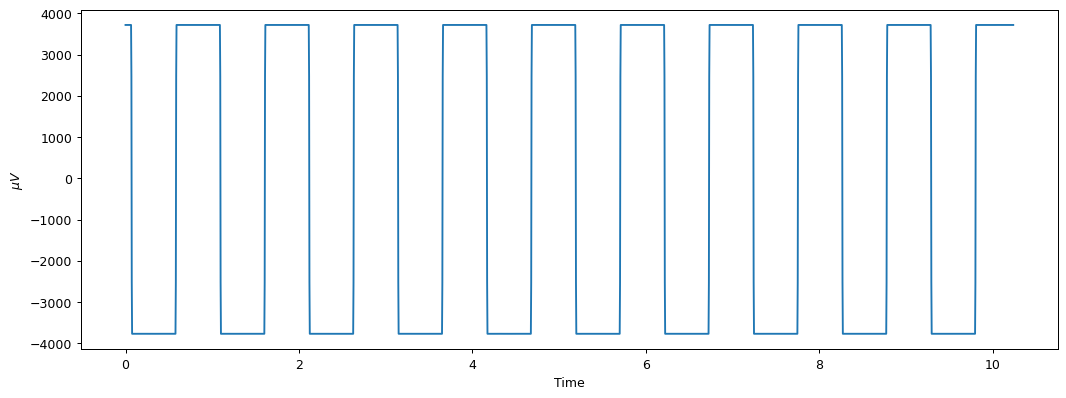

In [93]:
plt.figure(figsize=(14, 5), dpi=90)

ch0 = eeg_uv.T[0]
t = np.linspace(0, ch0.shape[0]/250, ch0.shape[0])

plt.plot(t, ch0)
plt.xlabel('Time')
plt.ylabel('$\mu V$')
plt.show()